In [235]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import wordcloud

[nltk_data] Downloading package punkt to /Users/natehiatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natehiatt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natehiatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Understanding

The unitary executive theory of the presidency holds that the presidency is the end-all, be-all when it comes to executive power. Significantly, such a belief implies that Congress can and should have no say over agencies that it created; now that they exist, they are solely under the direction of the president. As a result, as some scholars have argued, the locus of legislation within the US government has shifted from Congress to the presidency. This trend is furthered by Congress' willing abdication of their legislative responsibility. The result, according to many, is the rise of an Imperial Presidency. 

Our question here will be whether and to what extent executive orders have become more legislative in nature. It is worth noting at the outset that the unitary executive theory has much broader implications -- in particular, we are likely to see legislation happening also at the agency-rulemaking-level, which would also fall under the purview of the president's authority, per the theory. Still, examining executive orders will give us a good start in examining the extent to which the presidency has garnered more legislative powers. 

To do so, we'll build an NLP model based upon all legislation from [THE PAST XXXX YEARS], and all executive orders since Franklin D. Roosevelt's presidency -- the point which many presidential scholars identify as the start of the modern presidency. We'll take legislation as our positive class -- our "1" -- in training our supervised model, and executive orders as our negative class -- our "0". We'll then see how well our model can categorize legislative versus executive documents, and whether it has become more difficult to separate the two over time -- as the unitary executive theory of the presidency would suggest. 

# 2. Cleaning Data

## 2.i Cleaning Executive Orders

We'll begin by loading our dataset of all executive orders since FDR. We have the order number -- which we can later use to set the author of the order -- the text, the date, and for most of the orders, the title. For our purposes, we really just need the year it was issued and the text, which we will appropriately clean and tokenize.

In [2]:
# import EO csv file
eo_df = pd.read_csv('../data/executive_orders.csv', index_col=0)
eo_df.head()

,order_no,title,text,date
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933"
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933"
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933"
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933"
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933"


In [103]:
# creating a function to clean, tokenize, and lemmatize the text

from nltk.corpus import wordnet
# pos function taken from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, wordnet_pos(word)) for word in tokens]
    return tokens

In [104]:
# all text ends with "public domainpublic domainfalsefalse", so removing that
eo_df['text'] = eo_df['text'].str.replace('public domainpublic domainfalsefalse', '')
# apply function to our text
eo_df['cleaned_text'] = eo_df['text'].apply(clean_text)
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string,target,tokens,year,president
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appoint, operative, s...",august gennerich may appointed operative secre...,0,"[august, gennerich, may, appointed, operative,...",1933,roosevelt
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law...",1933,roosevelt
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, 5, b, act...",virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo...",1933,roosevelt
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, 401, 403, title, iv, part, ...",whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl...",1933,roosevelt
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, order, executive, order, 1032, date, ...",hereby ordered dated february far relates esta...,0,"[hereby, ordered, dated, february, far, relate...",1933,roosevelt


There's still a bunch of stuff we'll go back in and clean later -- "president," "united," "states," numerals, etc. -- but this is a good start.

In [105]:
print(eo_df['cleaned_text'][1000])

['virtue', 'authority', 'vested', 'president', 'constitution', 'law', 'united', 'state', 'america', 'include', 'section', '3301', '3302', 'title', '5', 'united', 'state', 'code', 'order', 'improve', 'presidential', 'management', 'intern', 'program', 'provide', 'recruitment', 'selection', 'increase', 'number', 'outstanding', 'employee', 'career', 'public', 'sector', 'management', 'hereby', 'order', 'section', '3', 'c', '1', 'executive', 'order', '12364', 'may', '24', '1982', 'amend', 'delete', 'two', 'hundred', 'insert', 'lieu', 'thereof', 'four', 'hundred', 'ronald', 'reaganthe', 'white', 'house', 'july', '12', '1988', 'file', 'office', 'federal', 'register', '11', '33', 'july', '13', '1988']


In [106]:
# combining the cleaned text back into a single string
eo_df['text_string'] = [' '.join(map(str, l)) for l in eo_df['cleaned_text']]
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string,target,tokens,year,president
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appoint, operative, s...",august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appointed, operative,...",1933,roosevelt
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law...",1933,roosevelt
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, 5, b, act...",virtue authority vested section 5 b act octobe...,0,"[virtue, authority, vested, section, act, octo...",1933,roosevelt
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, 401, 403, title, iv, part, ...",whereas section 401 403 title iv part ii legis...,0,"[whereas, section, title, iv, part, ii, legisl...",1933,roosevelt
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, order, executive, order, 1032, date, ...",hereby order executive order 1032 date februar...,0,"[hereby, ordered, dated, february, far, relate...",1933,roosevelt


## 2.ii Cleaning Laws

In [107]:
#importing data
laws_113 = pd.read_csv('../data/113_laws_text.csv')
laws_114 = pd.read_csv('../data/114_laws_text.csv')
laws_115 = pd.read_csv('../data/115_laws_text.csv')
laws_116 = pd.read_csv('../data/116_laws_text.csv')
laws_117 = pd.read_csv('../data/117_laws_text.csv')


In [108]:
# concatenating the two dataframes
laws = pd.concat([laws_113, laws_114, laws_115, laws_116, laws_117], axis=0)
laws.reset_index()
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...


In [109]:
laws.iloc[0]

Legislation Number                                              H.R. 6477
URL                     https://www.congress.gov/bill/114th-congress/h...
Congress                                                              114
Title                   Foreign Cultural Exchange Jurisdictional Immun...
Sponsor                                       Chabot, Steve [Rep.-R-OH-1]
Date of Introduction                                           12/08/2016
Chamber                                                                hr
Bill Number                                                          6477
Text                    This Act may be cited as the “Foreign Cultural...
Name: 0, dtype: object

In [110]:
laws.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1481 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Legislation Number    1481 non-null   object
 1   URL                   1481 non-null   object
 2   Congress              1481 non-null   object
 3   Title                 1481 non-null   object
 4   Sponsor               1481 non-null   object
 5   Date of Introduction  1481 non-null   object
 6   Chamber               1481 non-null   object
 7   Bill Number           1481 non-null   object
 8   Text                  1323 non-null   object
dtypes: object(9)
memory usage: 115.7+ KB


In [111]:
#dropping nulls
laws = laws.dropna(subset=['Text'])
laws["Text"].isna().sum()

0

In [112]:
laws.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1323 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Legislation Number    1323 non-null   object
 1   URL                   1323 non-null   object
 2   Congress              1323 non-null   object
 3   Title                 1323 non-null   object
 4   Sponsor               1323 non-null   object
 5   Date of Introduction  1323 non-null   object
 6   Chamber               1323 non-null   object
 7   Bill Number           1323 non-null   object
 8   Text                  1323 non-null   object
dtypes: object(9)
memory usage: 103.4+ KB


In [113]:
# process text using the same function as above
laws['cleaned_text'] = laws['Text'].apply(clean_text)
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...,"[act, may, cite, foreign, cultural, exchange, ..."
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...,"[act, may, cite, ensure, access, pacific, fish..."
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...,"[act, may, cite, federal, property, management..."
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...,"[act, may, cite, inspector, general, empowerme..."
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...,"[act, may, cite, promote, travel, commerce, na..."


In [114]:
laws.reset_index(drop=True, inplace=True)
laws["cleaned_text"][0]

['act',
 'may',
 'cite',
 'foreign',
 'cultural',
 'exchange',
 'jurisdictional',
 'immunity',
 'clarification',
 'act',
 'section',
 '1605',
 'title',
 '28',
 'united',
 'state',
 'code',
 'amend',
 'add',
 'end',
 'follow',
 'h',
 'jurisdictional',
 'immunity',
 'certain',
 'art',
 'exhibition',
 'activity',
 '1',
 'general',
 'export',
 'import',
 'work',
 'import',
 'united',
 'state',
 'foreign',
 'state',
 'pursuant',
 'agreement',
 'provide',
 'temporary',
 'exhibition',
 'display',
 'work',
 'enter',
 'foreign',
 'state',
 'owner',
 'custodian',
 'work',
 'united',
 'state',
 'one',
 'cultural',
 'educational',
 'institution',
 'within',
 'united',
 'state',
 'b',
 'president',
 'determination',
 'president',
 'president',
 'designee',
 'determine',
 'accordance',
 'subsection',
 'public',
 'law',
 '89',
 '259',
 '22',
 'u',
 'c',
 '2459',
 'work',
 'cultural',
 'significance',
 'temporary',
 'exhibition',
 'display',
 'work',
 'national',
 'interest',
 'c',
 'notice',
 'thereo

In [115]:
laws['text_string'] = [' '.join(map(str, l)) for l in laws['cleaned_text']]
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text,text_string
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...,"[act, may, cite, foreign, cultural, exchange, ...",act may cite foreign cultural exchange jurisdi...
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...,"[act, may, cite, ensure, access, pacific, fish...",act may cite ensure access pacific fishery act...
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...,"[act, may, cite, federal, property, management...",act may cite federal property management refor...
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...,"[act, may, cite, inspector, general, empowerme...",act may cite inspector general empowerment act...
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...,"[act, may, cite, promote, travel, commerce, na...",act may cite promote travel commerce national ...


In [116]:
# saving the cleaned data
laws.to_csv('../data/laws_cleaned.csv')
eo_df.to_csv('../data/eo_cleaned.csv')

# 3. EDA and Further Filtering

## 3.i Executive Orders

In [117]:
fdist = FreqDist()

eo_df['tokens'] = [text.split(" ") for text in eo_df['text_string']]
for list in eo_df['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('order', 11215),
 ('shall', 9088),
 ('state', 8459),
 ('united', 6885),
 ('section', 6368),
 ('agency', 5723),
 ('c', 5153),
 ('president', 4813),
 ('act', 4710),
 ('law', 4255),
 ('executive', 4103),
 ('federal', 4026),
 ('secretary', 3874),
 ('1', 3796),
 ('authority', 3666),
 ('may', 3395),
 ('include', 3291),
 ('b', 3224),
 ('amend', 3175),
 ('follow', 3105),
 ('hereby', 2991),
 ('2', 2891),
 ('u', 2776),
 ('service', 2750),
 ('national', 2683),
 ('government', 2546),
 ('department', 2473),
 ('sec', 2449),
 ('vested', 2443),
 ('provide', 2343),
 ('3', 2314),
 ('person', 1971),
 ('america', 1941),
 ('office', 1879),
 ('5', 1809),
 ('make', 1735),
 ('policy', 1730),
 ('constitution', 1714),
 ('information', 1692),
 ('public', 1614),
 ('appropriate', 1563),
 ('security', 1526),
 ('within', 1517),
 ('member', 1485),
 ('4', 1457),
 ('director', 1436),
 ('rule', 1416),
 ('function', 1416),
 ('use', 1403),
 ('program', 1396),
 ('general', 1389),
 ('action', 1377),
 ('employee', 1363),
 

From this list, some words will clearly identify the document as an executive order, and others are unnecessary or simply artefacts of webscraping. We will remove those.

The expanded list of stopwords will include: "president", "executive," "order,"
["sec"]

Also numerals: "1", "2", "3", "4", "5", "6", "7", "8", "9" ...

And individual letters: "b", "u", "e", "r"

And the names of the presidents at hand: "franklin", "roosevelt", "harry", "truman", "dwight", "eisenhower", "john", "kennedy", "lyndon", "johnson", "richard", "nixon", "gerald", "ford", "jimmy", "carter", "ronald", "reagan", "george", "bush", "bill", "clinton", "barack", "obama", "donald", "trump", "joseph", "biden"


In [118]:
from nltk.corpus import stopwords
stops_extended = stopwords.words('english') + ['president', 'executive', 'order', 'b', "c", "d", "e", "f", "g",
                                               "h", "j", "k", 'u', 'r',
                                               "franklin", "roosevelt", "harry", "truman", "dwight", "eisenhower",
                                               "john", "kennedy", "lyndon", "johnson", "richard", "nixon", "gerald",
                                                "ford", "jimmy", "carter", "ronald", "reagan", "george", "bush", "bill",
                                                "clinton", "barack", "obama", "donald", "trump", "joseph", "biden",]

stops_extended

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [119]:
# creating a second version of text cleaning function to remove the extended stopwords and numbers     
def clean_text_2(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = tokens = [lemmatizer.lemmatize(word, wordnet_pos(word)) for word in tokens]
    return tokens

In [120]:
# get clean version of the df and repeat intial filtering
eo_df = pd.read_csv('../data/executive_orders.csv', index_col=0)
eo_df['text'] = eo_df['text'].str.replace('public domainpublic domainfalsefalse', '')

# apply updated cleaning
eo_df['cleaned_text'] = eo_df['text'].apply(clean_text_2)

# create a text string column
eo_df['text_string'] = [' '.join(map(str, l)) for l in eo_df['cleaned_text']]
eo_df['target'] = 0
eo_df.head()

,order_no,title,text,date,cleaned_text,text_string,target
0,6071,Appointment of August A. Gennerich,august a. gennerich may be appointed an opera...,"March 8, 1933","[august, gennerich, may, appoint, operative, s...",august gennerich may appoint operative secret ...,0
1,6072,Transfer of Control and Jurisdiction of Certai...,canal zoneby virtue of the authority vested i...,"March 8, 1933","[canal, zoneby, virtue, authority, vested, law...",canal zoneby virtue authority vested law hereb...,0
2,6073,Regulations Concerning the Operation of Banks,by virtue of the authority vested in me by se...,"March 10, 1933","[virtue, authority, vested, section, act, octo...",virtue authority vested section act october st...,0
3,6084,Consolidating Federal Farm Credit Agencies,whereas sections 401 and 403 of title iv of p...,"March 27, 1933","[whereas, section, title, iv, part, ii, legisl...",whereas section title iv part ii legislative a...,0
4,6086,Establishing the Rio Grande Wildlife Refuge,it is hereby ordered that executive order no....,"March 28, 1933","[hereby, order, date, february, far, relates, ...",hereby order date february far relates establi...,0


In [121]:
# Repeating the frequency distribution
eo_df['tokens'] = [text.split(" ") for text in eo_df['text_string']]
for list in eo_df['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('shall', 18176),
 ('state', 16918),
 ('united', 13770),
 ('order', 13497),
 ('section', 12736),
 ('agency', 11446),
 ('act', 9420),
 ('law', 8510),
 ('federal', 8052),
 ('secretary', 7748),
 ('authority', 7332),
 ('may', 6790),
 ('include', 6582),
 ('amend', 6350),
 ('follow', 6210),
 ('hereby', 5982),
 ('service', 5500),
 ('national', 5366),
 ('c', 5153),
 ('government', 5092),
 ('department', 4946),
 ('sec', 4898),
 ('vested', 4886),
 ('president', 4827),
 ('provide', 4686),
 ('executive', 4146),
 ('person', 3942),
 ('america', 3882),
 ('1', 3796),
 ('office', 3758),
 ('make', 3470),
 ('policy', 3460),
 ('constitution', 3428),
 ('information', 3384),
 ('public', 3228),
 ('b', 3224),
 ('appropriate', 3126),
 ('security', 3052),
 ('within', 3034),
 ('member', 2970),
 ('2', 2891),
 ('director', 2872),
 ('rule', 2832),
 ('function', 2832),
 ('use', 2806),
 ('u', 2794),
 ('program', 2792),
 ('general', 2778),
 ('action', 2754),
 ('employee', 2726),
 ('establish', 2710),
 ('provision', 2

## 3.ii Laws

We'll now repeat this process for our laws dataframe.

In [122]:
laws['tokens'] = [text.split(" ") for text in laws['text_string']]
for list in laws['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('section', 122993),
 ('shall', 120563),
 ('state', 90760),
 ('act', 81250),
 ('secretary', 75801),
 ('provide', 58637),
 ('1', 58252),
 ('subsection', 56046),
 ('c', 55749),
 ('united', 54252),
 ('000', 53939),
 ('include', 52242),
 ('b', 50707),
 ('year', 50012),
 ('program', 49102),
 ('may', 47657),
 ('paragraph', 45029),
 ('service', 43867),
 ('2', 40512),
 ('agency', 37741),
 ('title', 37271),
 ('available', 36604),
 ('fund', 36446),
 ('federal', 36343),
 ('make', 36170),
 ('use', 34483),
 ('department', 33627),
 ('stat', 32375),
 ('law', 30130),
 ('amount', 29856),
 ('insert', 29831),
 ('defense', 29412),
 ('committee', 29203),
 ('u', 28865),
 ('national', 28522),
 ('appropriate', 28191),
 ('date', 27849),
 ('follow', 27658),
 ('term', 26788),
 ('strike', 26442),
 ('fiscal', 25882),
 ('public', 25757),
 ('3', 25134),
 ('described', 24701),
 ('information', 24607),
 ('sec', 24601),
 ('amend', 23345),
 ('report', 22852),
 ('plan', 22042),
 ('project', 22000),
 ('activity', 21993),

In [123]:
# further stops
stops_extended_2 = stops_extended + ['congress']

# creating a third version of text cleaning function to remove the extended stopwords and numbers     
def clean_text_3(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended_2 and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, wordnet_pos(word)) for word in tokens]
    return tokens

In [124]:
# apply updated cleaning
laws['cleaned_text'] = laws['Text'].apply(clean_text_3)

# create a text string column
laws['text_string'] = [' '.join(map(str, l)) for l in laws['cleaned_text']]
laws['target'] = 1
laws.head()

,Legislation Number,URL,Congress,Title,Sponsor,Date of Introduction,Chamber,Bill Number,Text,cleaned_text,text_string,tokens,target
0,H.R. 6477,https://www.congress.gov/bill/114th-congress/h...,114,Foreign Cultural Exchange Jurisdictional Immun...,"Chabot, Steve [Rep.-R-OH-1]",12/08/2016,hr,6477,This Act may be cited as the “Foreign Cultural...,"[act, may, cite, foreign, cultural, exchange, ...",act may cite foreign cultural exchange jurisdi...,"[act, may, cite, foreign, cultural, exchange, ...",1
1,H.R. 6452,https://www.congress.gov/bill/114th-congress/h...,114,Ensuring Access to Pacific Fisheries Act,"Radewagen, Aumua Amata Coleman [Del.-R-AS-At L...",12/07/2016,hr,6452,This Act may be cited as the “Ensuring Access ...,"[act, may, cite, ensure, access, pacific, fish...",act may cite ensure access pacific fishery act...,"[act, may, cite, ensure, access, pacific, fish...",1
2,H.R. 6451,https://www.congress.gov/bill/114th-congress/h...,114,Federal Property Management Reform Act of 2016,"Denham, Jeff [Rep.-R-CA-10]",12/07/2016,hr,6451,This Act may be cited as the “Federal Property...,"[act, may, cite, federal, property, management...",act may cite federal property management refor...,"[act, may, cite, federal, property, management...",1
3,H.R. 6450,https://www.congress.gov/bill/114th-congress/h...,114,Inspector General Empowerment Act of 2016,"Chaffetz, Jason [Rep.-R-UT-3]",12/07/2016,hr,6450,This Act may be cited as the “Inspector Genera...,"[act, may, cite, inspector, general, empowerme...",act may cite inspector general empowerment act...,"[act, may, cite, inspector, general, empowerme...",1
4,H.R. 6431,https://www.congress.gov/bill/114th-congress/h...,114,"Promoting Travel, Commerce, and National Secur...","Kuster, Ann M. [Rep.-D-NH-2]",12/02/2016,hr,6431,This Act may be cited as the “Promoting Travel...,"[act, may, cite, promote, travel, commerce, na...",act may cite promote travel commerce national ...,"[act, may, cite, promote, travel, commerce, na...",1


In [125]:
# Repeating the frequency distribution
laws['tokens'] = [text.split(" ") for text in laws['text_string']]
for list in laws['tokens']:
    for word in list:
        fdist[word] += 1

fdist.most_common(200)

[('section', 233250),
 ('shall', 222950),
 ('state', 164602),
 ('act', 153080),
 ('secretary', 143854),
 ('provide', 112588),
 ('subsection', 109944),
 ('year', 98582),
 ('include', 97902),
 ('program', 95412),
 ('united', 94734),
 ('paragraph', 88732),
 ('may', 88524),
 ('service', 82234),
 ('available', 72382),
 ('fund', 72004),
 ('title', 71944),
 ('make', 68870),
 ('use', 66160),
 ('federal', 64634),
 ('agency', 64036),
 ('stat', 63662),
 ('department', 62308),
 ('amount', 59272),
 ('insert', 58522),
 ('1', 58253),
 ('defense', 56190),
 ('committee', 55832),
 ('c', 55749),
 ('000', 53939),
 ('date', 53400),
 ('appropriate', 53256),
 ('term', 52252),
 ('strike', 52162),
 ('law', 51750),
 ('national', 51678),
 ('fiscal', 51482),
 ('b', 50707),
 ('follow', 49106),
 ('described', 48480),
 ('public', 48286),
 ('information', 45830),
 ('sec', 44304),
 ('project', 43506),
 ('report', 43170),
 ('plan', 42578),
 ('activity', 42458),
 ('subparagraph', 42194),
 ('health', 40920),
 ('2', 40514

# 3.iii Both

In [126]:
# add year column
eo_df['year'] = pd.to_datetime(eo_df['date']).dt.year
#eo_df['year'] = eo_df['year'].astype(int)
laws['year'] = pd.to_datetime(laws['Date of Introduction']).dt.year

In [127]:
eo_df[eo_df['year'].isna()]

,order_no,title,text,date,cleaned_text,text_string,target,tokens,year
337,10338,NaN,by virtue of the authority vested in me by sec...,NaN,"[virtue, authority, vested, section, mutual, s...",virtue authority vested section mutual securit...,0,"[virtue, authority, vested, section, mutual, s...",NaN
338,10339,NaN,by virtue of the authority vested in me by sec...,NaN,"[virtue, authority, vested, section, act, enti...",virtue authority vested section act entitle ac...,0,"[virtue, authority, vested, section, act, enti...",NaN
548,11515,NaN,"march 13, 1970 by virtue of the authority ves...",NaN,"[march, virtue, authority, vested, united, sta...",march virtue authority vested united state her...,0,"[march, virtue, authority, vested, united, sta...",NaN
2052,13704,NaN,federal register part iii the president exe...,NaN,"[federal, register, part, iii, presidential, i...",federal register part iii presidential innovat...,0,"[federal, register, part, iii, presidential, i...",NaN
2134,13866,NaN,please see this document's talk page for detai...,NaN,"[please, see, document, talk, page, detail, ve...",please see document talk page detail verificat...,0,"[please, see, document, talk, page, detail, ve...",NaN
2158,13962,NaN,"executive order 13962 of december 8, 2020 ensu...",NaN,"[december, ensure, access, united, state, gove...",december ensure access united state government...,0,"[december, ensure, access, united, state, gove...",NaN


There's just a handfull of rows with missing information, so we'll fill it in manually.

In [128]:
# order 103338 https://www.presidency.ucsb.edu/documents/executive-order-10338-coordination-procedures-under-section-507-the-mutual-security-act
eo_df.at[337, 'date'] = 'April 4, 1952'
eo_df.at[337, 'year'] = 1952
eo_df.at[337, 'title'] = 'Coordination Procedures Under Section 507 of the Mutual Security Act of 1951'

# order 10339 https://www.archives.gov/federal-register/executive-orders/1952.html#10339
eo_df.at[338, 'date'] = 'April 4, 1952'
eo_df.at[338, 'year'] = 1952
eo_df.at[338, 'title'] = 'Extensions of Time Relating to the Disposition of Certain Housing'

# order 11515
eo_df.at[548, 'date'] = 'March 13, 1970'
eo_df.at[548, 'year'] = 1970

# order 13704 https://www.govinfo.gov/content/pkg/DCPD-201500563/pdf/DCPD-201500563.pdf
eo_df.at[2052, 'date'] = 'August 17, 2015'
eo_df.at[2052, 'year'] = 2015
eo_df.at[2052, 'title'] = 'Presidential Innovation Fellows Program'


# order 13866 https://www.presidency.ucsb.edu/documents/executive-order-13866-adjustments-certain-rates-pay
eo_df.at[2134, 'date'] = 'March 28, 2019'
eo_df.at[2134, 'year'] = 2019
eo_df.at[2134, 'title'] = 'Adjustments of Certain Rates of Pay'

# order 13867 https://www.federalregister.gov/documents/2019/04/15/2019-07645/issuance-of-permits-with-respect-to-facilities-and-land-transportation-crossings-at-the
eo_df.at[2135, 'date'] = 'April 10, 2019'
eo_df.at[2135, 'year'] = 2019
eo_df.at[2135, 'title'] = 'Issuance of Permits with Respect to Facilities and Land Transportation Crossings at the International Boundaries of the United States'

# order 13962 https://www.presidency.ucsb.edu/documents/executive-order-13962-ensuring-access-united-states-government-covid-19-vaccines
eo_df.at[2158, 'date'] = 'December 8, 2020'
eo_df.at[2158, 'year'] = 2020
eo_df.at[2158, 'title'] = 'Ensuring Access to United States Government COVID-19 Vaccines'

In [129]:
eo_df.isna().sum()

order_no        0
title           9
text            0
date            0
cleaned_text    0
text_string     0
target          0
tokens          0
year            0
dtype: int64

We don't really care that the title is missing for a few orders.

In [130]:
# Also adding the president responsible for a given order
# https://www.presidency.ucsb.edu/statistics/data/executive-orders

def assign_president(order_no):
    if order_no <= 9537:
        return 'roosevelt'
    elif order_no <= 10431:
        return 'truman'
    elif order_no <= 10913:
        return 'eisenhower'
    elif order_no <= 11127:
        return 'kennedy'
    elif order_no <= 11451:
        return 'johnson'
    elif order_no <= 11797:
        return 'nixon'
    elif order_no <= 11966:
        return 'ford'
    elif order_no <= 12286:
        return 'carter'
    elif order_no <= 12667:
        return 'reagan'
    elif order_no <= 12833:
        return 'bush 1'
    elif order_no <= 13197:
        return 'clinton'
    elif order_no <= 13488:
        return 'bush 2'
    elif order_no <= 13764:
        return 'obama'
    elif order_no <= 13984:
        return 'trump'
    else:
        return 'biden'

eo_df['president'] = eo_df['order_no'].apply(assign_president)

In [131]:
eo_df['president'].value_counts()

president
reagan        381
clinton       364
bush 2        291
obama         218
roosevelt     186
truman        173
bush 1        166
trump         109
eisenhower     94
biden          82
kennedy        57
carter         51
nixon          37
johnson        31
ford           13
Name: count, dtype: int64

In [132]:
laws.isna().sum()

Legislation Number      0
URL                     0
Congress                0
Title                   0
Sponsor                 0
Date of Introduction    0
Chamber                 0
Bill Number             0
Text                    0
cleaned_text            0
text_string             0
tokens                  0
target                  0
year                    0
dtype: int64

We'll now go ahead and resave the dataframes:

In [133]:
# saving the cleaned data
laws.to_csv('../data/laws_cleaned.csv')
eo_df.to_csv('../data/eo_cleaned.csv')

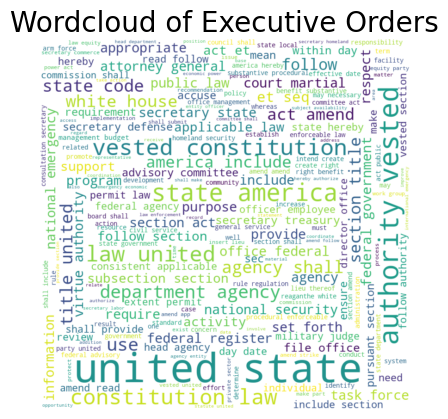

In [245]:
# Wordclouds
# EO

wordcloud_eo = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stops_extended_2, 
                min_font_size = 10).generate(' '.join(eo_df['text_string']))
plt.imshow(wordcloud_eo, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Executive Orders', fontsize=20);

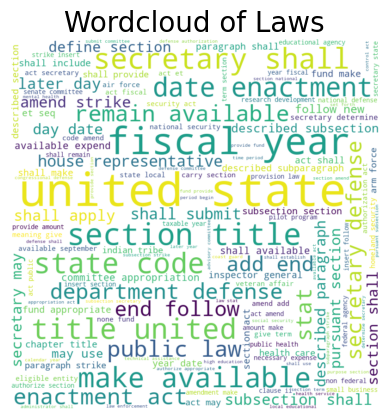

In [244]:
# Wordcloud of laws
wordcloud_laws = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stops_extended_2, 
                min_font_size = 10).generate(' '.join(laws['text_string']))
plt.imshow(wordcloud_laws, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Laws', fontsize=20);

# 4. Modelling

In [134]:
# starting off with some functions we'll keep using
def evaluate_grid(gs):
    y_pred = gs.predict(X_test)
    print("Best Params: " + str(gs.best_params_)) 
    print("Best CV Accuracy: " + str(gs.best_score_)) 
    print("Train Accuracy: " + str(gs.score(X_train, y_train)))

def plot_cm(y_test, gs):
    '''
    Takes in true values and predicted values and plots a confusion matrix
    '''
    y_pred = gs.predict(X_test)    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Executive Order', 'Legislation'])
    disp.plot();

In [135]:
# combining the dataframes
filtered_eo = eo_df[['year', 'text_string', 'target']]
filtered_laws = laws[['year', 'text_string', 'target']]
df = pd.concat([filtered_eo, filtered_laws])
# setting year as integer
df['year'] = df['year'].astype(int)
# creating a list of tokens
df['tokens'] = [text.split(" ") for text in df['text_string']]
df

,year,text_string,target,tokens
0,1933,august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appoint, operative, s..."
1,1933,canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law..."
2,1933,virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo..."
3,1933,whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl..."
4,1933,hereby order date february far relates establi...,0,"[hereby, order, date, february, far, relates, ..."
...,...,...,...,...
1318,2022,act may cite vawa technical amendment act subp...,1,"[act, may, cite, vawa, technical, amendment, a..."
1319,2021,limitation section title united state code rec...,1,"[limitation, section, title, united, state, co..."
1320,2021,disapproves rule submit office comptroller cur...,1,"[disapproves, rule, submit, office, comptrolle..."
1321,2021,disapproves rule submit administrator environm...,1,"[disapproves, rule, submit, administrator, env..."


In [136]:
X = df['text_string']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [137]:
# Dummy model
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print("Train Accuracy: " + str(dummy.score(X_train, y_train)))
print("Test Accuracy: " + str(dummy.score(X_test, y_test)))

Train Accuracy: 0.6325174825174825
Test Accuracy: 0.6201117318435754


## 4.i Multinomial Naive Bayes

We'll start off with a Multinomial Naive Bayes model. Most of our grid search parameters will involve the Tf-IDF Vectorizer -- the maximum and minimum number of documents in which the word appears, and also whether we're looking for unigrams, bigrams, trigrams, or some combination thereof.

In [138]:
# creating a pipeline
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# setting up the parameters
param_grid_nb = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (3, 3)],
    'tfidf__min_df': [1, 3, 5, 10],
    'nb__alpha': [0.01, 0.1, 1]
}

# grid search
gs_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, n_jobs=-1)

In [139]:
gs_nb.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.01, 0.1, 1],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 3, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)]})

In [140]:
evaluate_grid(gs_nb)

Best Params: {'nb__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__min_df': 3, 'tfidf__ngram_range': (3, 3)}
Best CV Accuracy: 0.9951048951048952
Train Accuracy: 0.9993006993006993


Interestingly, searching exclusively for trigrams apepars to be the most accurate in terms of our accuracy on validation data. We were able to successfully predict whether a document was executive or legislative correctly almost every time, as can be seen in the below confusion matrix.

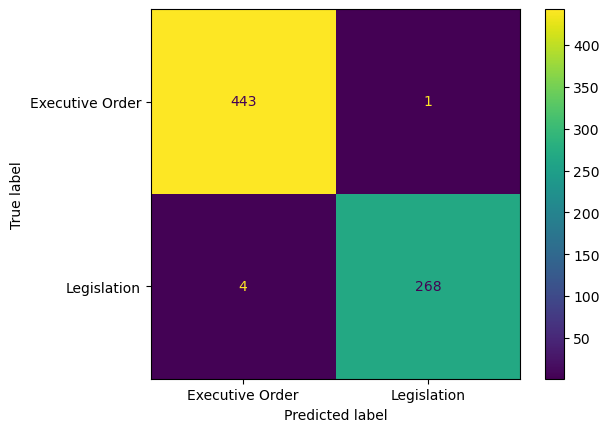

In [141]:
plot_cm(y_test, gs_nb)

We'll now take a look at the different words that were the most significant in classifying the different documents.

In [142]:
# instantiate vectorizer
# using params from grid search
tfidf_nb = TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(3, 3))
X_train_tfidf_nb = tfidf_nb.fit_transform(X_train)
X_test_tfidf_nb = tfidf_nb.transform(X_test)

# fitting to Naive Bayes classifier
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train_tfidf_nb, y_train)
#y_pred_nb = nb.predict(X_test_tfidf_nb)

# Creating tfidf matrix:
X_tfidf_nb = tfidf_nb.transform(df['text_string'])
result_df = df.copy()
result_df.reset_index(inplace=True)
result_df["tfidf"] = X_tfidf_nb.toarray().tolist()
result_df.head()

,index,year,text_string,target,tokens,tfidf
0,0,1933,august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appoint, operative, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1933,canal zoneby virtue authority vested law hereb...,0,"[canal, zoneby, virtue, authority, vested, law...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,1933,virtue authority vested section act october st...,0,"[virtue, authority, vested, section, act, octo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,1933,whereas section title iv part ii legislative a...,0,"[whereas, section, title, iv, part, ii, legisl...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1933,hereby order date february far relates establi...,0,"[hereby, order, date, february, far, relates, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [143]:
tfidf_nb.get_feature_names_out()

array(['0010601101ain house laboratory', '001f 18e fighter',
       '001joint urgent operational', ..., 'zoonotic infectious disease',
       'état decree date', 'état decree military'], dtype=object)

Text(50.7222222222222, 0.5, '')

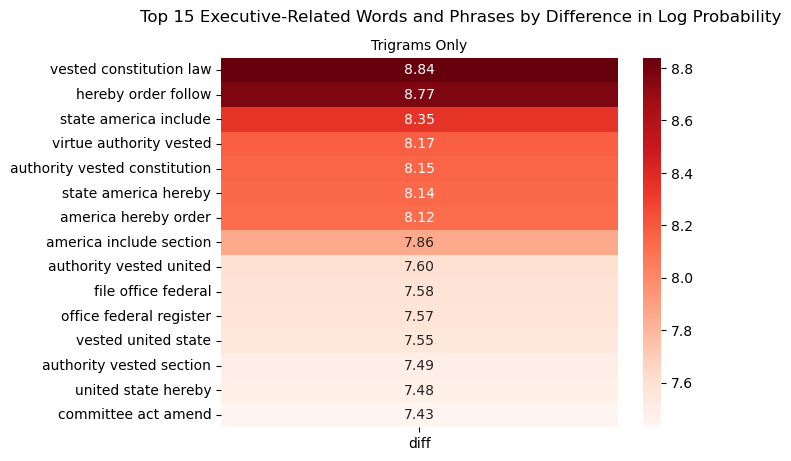

In [144]:
features_nb = pd.DataFrame((zip(tfidf_nb.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb["diff"] = features_nb[2] - features_nb[1]

heatmap_nb = features_nb[[0, "diff"]].copy()
heatmap_nb = heatmap_nb.rename(columns={0: "word"})
heatmap_nb = heatmap_nb.sort_values(by="diff", ascending=True)
heatmap_nb = heatmap_nb.set_index("word")
heatmap_nb

sns.heatmap(heatmap_nb[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Trigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


In [145]:
features_nb.sort_values(by="diff", ascending=True).head(50)

,0,1,2,diff
166390,vested constitution law,-5.090887,-13.929494,-8.838608
71388,hereby order follow,-5.158309,-13.929494,-8.771185
147447,state america include,-5.580576,-13.929494,-8.348918
167060,virtue authority vested,-5.754914,-13.929494,-8.174581
19447,authority vested constitution,-5.056451,-13.208201,-8.151751
147444,state america hereby,-5.792606,-13.929494,-8.136888
11652,america hereby order,-5.808314,-13.929494,-8.121180
11675,america include section,-6.070120,-13.929494,-7.859374
19462,authority vested united,-6.329050,-13.929494,-7.600444
61752,file office federal,-6.350744,-13.929494,-7.578751


Words that we'll use to further filter the corpus:

Artefacts: "reaganthe"

Presidency-related: "commander", "chief"

Authority-related: "authority", "vested", "constitution"

Other: "state", "ordered", "follows", "hereby", "united", "states", "white", "house"

Text(50.7222222222222, 0.5, '')

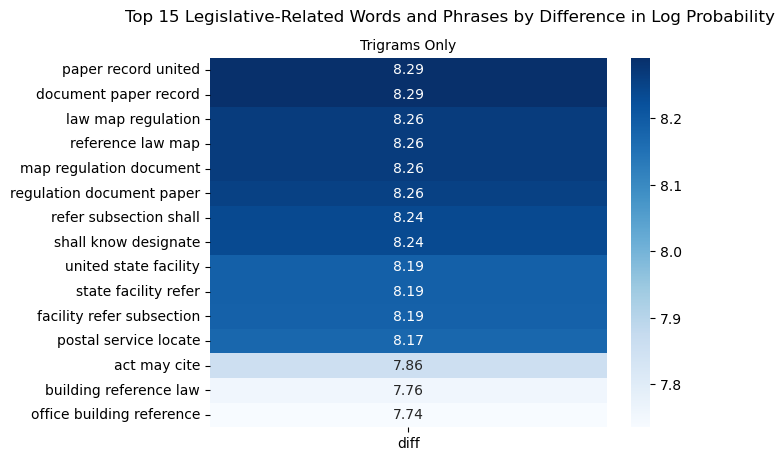

In [146]:
heatmap_nb = features_nb[[0, "diff"]].copy()
heatmap_nb = heatmap_nb.rename(columns={0: "word"})
heatmap_nb = heatmap_nb.sort_values(by="diff", ascending=False)
heatmap_nb = heatmap_nb.set_index("word")
heatmap_nb

sns.heatmap(heatmap_nb[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Trigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")

In [147]:
heatmap_nb.sort_values(by="diff", ascending=False).head(50)

,diff
word,
paper record united,8.291152
document paper record,8.291120
law map regulation,8.264330
reference law map,8.264330
map regulation document,8.264330
regulation document paper,8.255695
refer subsection shall,8.238523
shall know designate,8.235691
united state facility,8.188741


In [148]:
# Repeating the above process to get unigrams only
# instantiate vectorizer
# using params from grid search
tfidf_nb_unigrams = TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(1, 1))
X_train_tfidf_nb_unigrams = tfidf_nb_unigrams.fit_transform(X_train)
X_test_tfidf_nb_unigrams = tfidf_nb_unigrams.transform(X_test)

# fitting to Naive Bayes classifier
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train_tfidf_nb_unigrams, y_train)
#y_pred_nb = nb.predict(X_test_tfidf_nb)

# Creating tfidf matrix:
X_tfidf_nb = tfidf_nb_unigrams.transform(df['text_string'])
result_df_unigrams = df.copy()
result_df_unigrams.reset_index(inplace=True)
result_df_unigrams["tfidf"] = X_tfidf_nb.toarray().tolist()
result_df_unigrams.head(1)

,index,year,text_string,target,tokens,tfidf
0,0,1933,august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appoint, operative, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Text(50.72222222222221, 0.5, '')

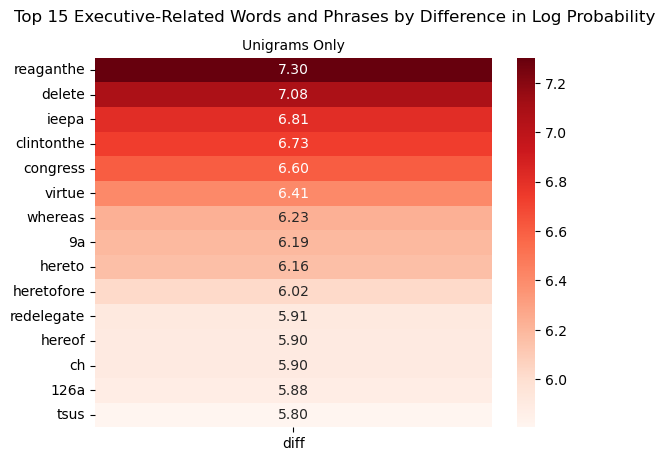

In [149]:
features_nb_unigrams = pd.DataFrame((zip(tfidf_nb_unigrams.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb_unigrams["diff"] = features_nb_unigrams[2] - features_nb_unigrams[1]

heatmap_nb_unigrams = features_nb_unigrams[[0, "diff"]].copy()
heatmap_nb_unigrams = heatmap_nb_unigrams.rename(columns={0: "word"})
heatmap_nb_unigrams = heatmap_nb_unigrams.sort_values(by="diff", ascending=True)
heatmap_nb_unigrams = heatmap_nb_unigrams.set_index("word")

sns.heatmap(heatmap_nb_unigrams[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


Text(50.72222222222221, 0.5, '')

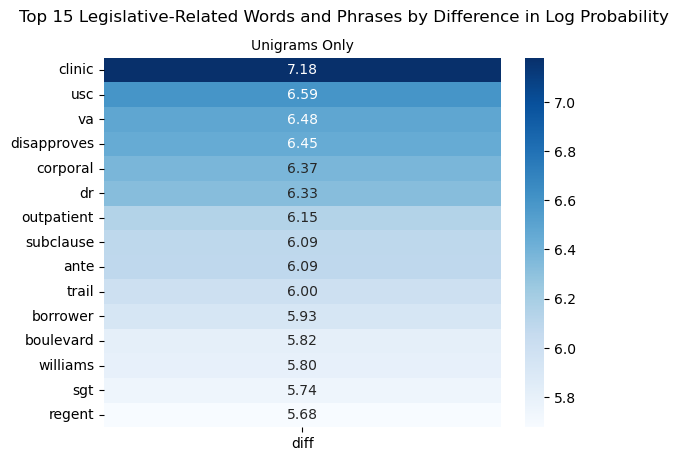

In [150]:
features_nb_unigrams = pd.DataFrame((zip(tfidf_nb_unigrams.get_feature_names_out(), nb.feature_log_prob_[0], nb.feature_log_prob_[1])))
features_nb_unigrams["diff"] = features_nb_unigrams[2] - features_nb_unigrams[1]

heatmap_nb_unigrams = features_nb_unigrams[[0, "diff"]].copy()
heatmap_nb_unigrams = heatmap_nb_unigrams.rename(columns={0: "word"})
heatmap_nb_unigrams = heatmap_nb_unigrams.sort_values(by="diff", ascending=False)
heatmap_nb_unigrams = heatmap_nb_unigrams.set_index("word")

sns.heatmap(heatmap_nb_unigrams[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams Only", fontsize=10)
plt.xlabel("")
plt.ylabel("")


The unigrams are slightly odd -- in the executive case, there appear to be a lot of typos and artefacts of web-scraping. The legislative case reveals how many of the laws that Congress enacts have to do with the (re-)naming of Post Offices.

## 4.ii Random Forest

In [151]:
from sklearn.ensemble import RandomForestClassifier
# instantiate vectorizer
# using params from grid search

X = df[['text_string']]
y = df['target']

# creating a pipeline
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# setting up the parameters
param_grid_rf = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'rf__n_estimators': [100, 300],
    'rf__criterion': ['gini', 'log_loss'],
    'rf__max_depth': [None, 10, 50],
    #'rf__max_features': [None, 'sqrt', 'log2']
}

# grid search
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, n_jobs=-1)

In [152]:
gs_rf.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'log_loss'],
                         'rf__max_depth': [None, 10, 50],
                         'rf__n_estimators': [100, 300],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]})

In [153]:
evaluate_grid(gs_rf)

Best Params: {'rf__criterion': 'log_loss', 'rf__max_depth': None, 'rf__n_estimators': 100, 'tfidf__max_df': 0.75, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best CV Accuracy: 0.9965033734361973
Train Accuracy: 1.0


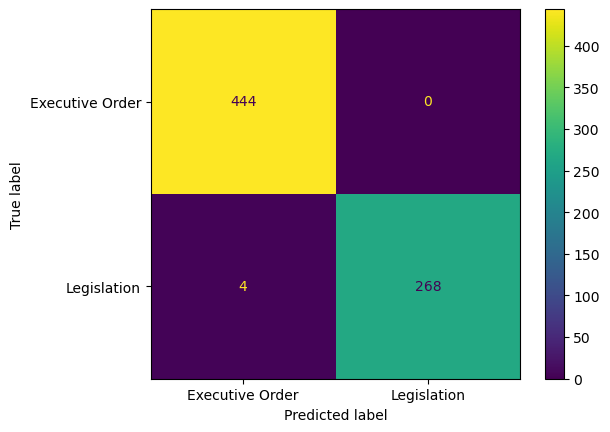

In [154]:
plot_cm(y_test, gs_rf)

In [155]:
feats = {} 
for feature, importance in zip(gs_rf.best_estimator_.named_steps['tfidf'].get_feature_names_out(), gs_rf.best_estimator_.named_steps['rf'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).head(50)

,Gini-importance
hereby,0.081205
vested,0.059645
cite,0.030545
authority,0.027524
constitution,0.027092
order,0.024843
america,0.024481
enactment,0.018179
map,0.015367
insert,0.015291


In [156]:
importances.sort_values(by='Gini-importance', ascending=False).head(15)

,Gini-importance
hereby,0.081205
vested,0.059645
cite,0.030545
authority,0.027524
constitution,0.027092
order,0.024843
america,0.024481
enactment,0.018179
map,0.015367
insert,0.015291


## 4.iii XGBoost

In [157]:
import xgboost as xgb
from xgboost import XGBClassifier

In [158]:
# creating a pipeline
pipe_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

# setting up the parameters
# starting with a basic xgb model; running two different solvers
param_grid_xgb = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1,3), (3, 3)],
    'xgb__booster': ['gbtree', 'gblinear'],
}

# grid search
gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, n_jobs=-1)

In [159]:
gs_xgb.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)],
                         'xgb__booster': ['gbtree', 'gblinear']})

In [160]:
evaluate_grid(gs_xgb)

Best Params: {'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'xgb__booster': 'gbtree'}
Best CV Accuracy: 0.9954545454545455
Train Accuracy: 1.0


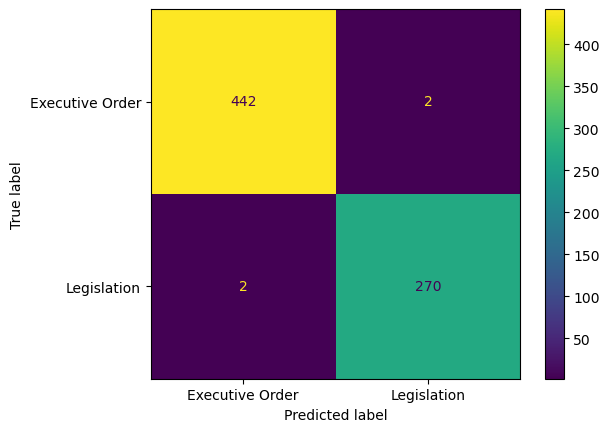

In [161]:
plot_cm(y_test, gs_xgb)

In [162]:
feats = {} 
for feature, importance in zip(gs_xgb.best_estimator_.named_steps['tfidf'].get_feature_names_out(), gs_xgb.best_estimator_.named_steps['xgb'].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False).head(50)

,Gini-importance
authority vested,0.665425
vested,0.082584
whereas,0.051036
white house,0.015788
cleveland,0.010929
authenticity,0.010826
proclamation,0.009147
hereby,0.008547
effectuate,0.008443
may cite,0.008281


authority-related: "vested", "authorized"

executive order artefacts: "white", "house", 

quasi-authority-related: "whereas", "hereby",

too explicit to keep: "act", "law", "resolution"

procedural words: "cited", "reference", "subsection", "paragraph"

# 5. Adding Stopwords

We can now combine our lists of the words we want to filter:

"reaganthe", "commander", "chief", "white", "house", "authority", "vested", "constitution", "authorized", "whereas", "hereby", "united", "states", "ordered", "follows", "act", "law", "resolution", "cited", "reference", "subsection", "paragraph"

In [163]:
new_stops = ["reaganthe", "commander", "chief", "white", "house", "authority", "vested", "constitution", "authorized", "whereas", "hereby", "united", "states", "ordered", "follows", "act", "law", "resolution", "cited", "reference", "subsection", "paragraph"] + ["virtue", "section", "ii", "iii", "iv", "v", "vi", "title", "part"]
stops_extended_3 = stops_extended + new_stops
stops_extended_3

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [164]:
# recreating our function with our new stopwords
def clean_text_4(text):
    # lower case
    text = text.lower()
    # remove punctuation and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    # remove extended stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in stops_extended_3 and not word.isdigit()]
    # lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = tokens = [lemmatizer.lemmatize(word, wordnet_pos(word)) for word in tokens]
    return tokens

In [165]:
# applying the function to df
df_2 = df.copy()
df_2['cleaned_text'] = df_2['text_string'].apply(clean_text_4)
df_2['text_string'] = [' '.join(map(str, l)) for l in df_2['cleaned_text']]
df_2.head()

,year,text_string,target,tokens,cleaned_text
0,1933,august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appoint, operative, s...","[august, gennerich, may, appoint, operative, s..."
1,1933,canal zoneby building locate cristobal canal z...,0,"[canal, zoneby, virtue, authority, vested, law...","[canal, zoneby, building, locate, cristobal, c..."
2,1933,october stat l amend march say march issue fol...,0,"[virtue, authority, vested, section, act, octo...","[october, stat, l, amend, march, say, march, i..."
3,1933,legislative appropriation fiscal year amend co...,0,"[whereas, section, title, iv, part, ii, legisl...","[legislative, appropriation, fiscal, year, ame..."
4,1933,date february far relates establishment rio gr...,0,"[hereby, order, date, february, far, relates, ...","[date, february, far, relates, establishment, ..."


In [166]:
X = df_2['text_string']
y = df_2['target']

# repeat train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## 5.i Multinomial Naive Bayes II

In [167]:
# create pipe
pipe_nb_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# params
param_grid_nb_2 = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (3, 3)],
    'tfidf__min_df': [1, 5, 10],
    'nb__alpha': [0.01, 0.1, 1]
}

# grid search
gs_nb_2 = GridSearchCV(pipe_nb_2, param_grid_nb_2, cv=5, n_jobs=-1)

In [168]:
gs_nb_2.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [0.01, 0.1, 1],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)]})

In [169]:
evaluate_grid(gs_nb_2)

Best Params: {'nb__alpha': 0.1, 'tfidf__max_df': 0.5, 'tfidf__min_df': 5, 'tfidf__ngram_range': (2, 2)}
Best CV Accuracy: 0.9902097902097904
Train Accuracy: 0.9986013986013986


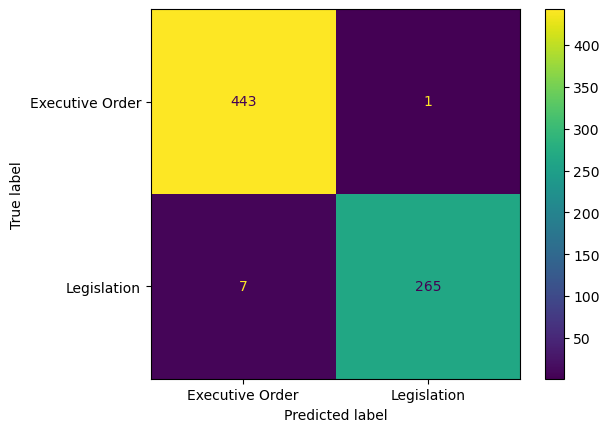

In [170]:
plot_cm(y_test, gs_nb_2)

Text(50.7222222222222, 0.5, '')

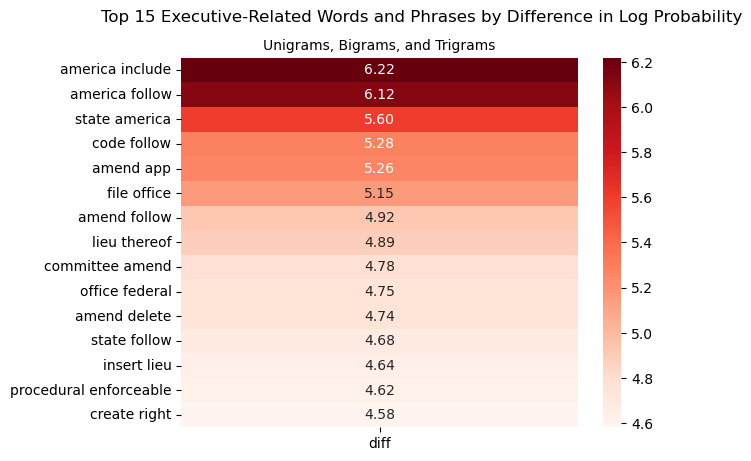

In [171]:
# repeating the process for getting most important features
features_nb_2 = pd.DataFrame((zip(gs_nb_2.best_estimator_.named_steps['tfidf'].get_feature_names_out(), gs_nb_2.best_estimator_.named_steps['nb'].feature_log_prob_[0], gs_nb_2.best_estimator_.named_steps['nb'].feature_log_prob_[1])))
features_nb_2["diff"] = features_nb_2[2] - features_nb_2[1]

heatmap_nb_2 = features_nb_2[[0, "diff"]].copy()
heatmap_nb_2 = heatmap_nb_2.rename(columns={0: "word"})
heatmap_nb_2 = heatmap_nb_2.sort_values(by="diff", ascending=True)
heatmap_nb_2 = heatmap_nb_2.set_index("word")
heatmap_nb_2

sns.heatmap(heatmap_nb_2[0:15].abs(), cmap="Reds", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Executive-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams, Bigrams, and Trigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

In [172]:
features_nb_2.sort_values(by="diff", ascending=True).head(50)

,0,1,2,diff
5043,america include,-5.912395,-12.130575,-6.218180
5037,america follow,-6.014501,-12.133250,-6.118750
78685,state america,-5.312193,-10.911468,-5.599276
14833,code follow,-6.790389,-12.074781,-5.284392
4870,amend app,-6.856937,-12.118250,-5.261312
33760,file office,-6.798936,-11.949449,-5.150513
4902,amend follow,-6.930986,-11.852994,-4.922008
46338,lieu thereof,-7.224342,-12.111760,-4.887418
15832,committee amend,-6.890592,-11.668326,-4.777734
53676,office federal,-6.769973,-11.516097,-4.746125


Text(50.72222222222221, 0.5, '')

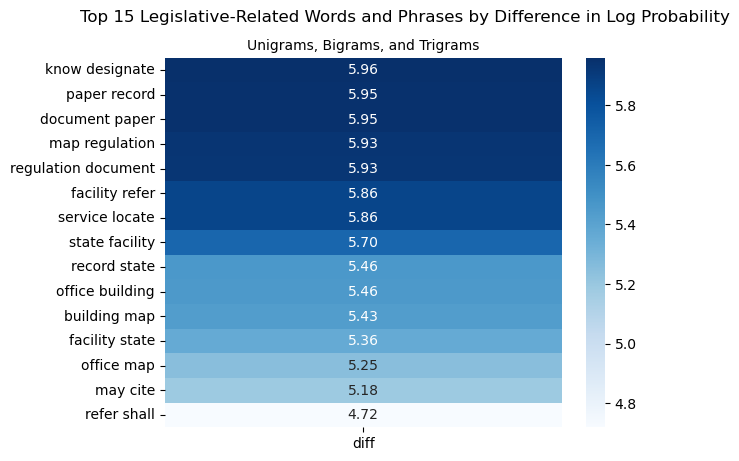

In [173]:
heatmap_nb_2 = features_nb_2[[0, "diff"]].copy()
heatmap_nb_2 = heatmap_nb_2.rename(columns={0: "word"})
heatmap_nb_2 = heatmap_nb_2.sort_values(by="diff", ascending=False)
heatmap_nb_2 = heatmap_nb_2.set_index("word")
heatmap_nb_2

sns.heatmap(heatmap_nb_2[0:15].abs(), cmap="Blues", annot=True, fmt=".2f",)
plt.suptitle("Top 15 Legislative-Related Words and Phrases by Difference in Log Probability", fontsize=12)
plt.title("Unigrams, Bigrams, and Trigrams", fontsize=10)
plt.xlabel("")
plt.ylabel("")

Notes
* Executive orders seem to rely much more heavily on "America." That would make sense, given that the president is the closest thing Americans have to a national representative.
* Legislative texts still emphasize maps, papers, regulations and the like. This, in part, reflects the fact that so many of the passed laws from Congress have to do with (re-)naming Post Offices. 

## 5.ii RF II

In [174]:
pipe_rf_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# setting up the parameters
param_grid_rf_2 = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1,2), (2, 2), (1, 3), (3, 3)],
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 10, 50],
}

# grid search
gs_rf_2 = GridSearchCV(pipe_rf_2, param_grid_rf_2, cv=3, n_jobs=-1)

In [175]:
gs_rf_2.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 10, 50],
                         'rf__n_estimators': [100, 300],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)]})

In [176]:
evaluate_grid(gs_rf_2)

Best Params: {'rf__max_depth': None, 'rf__n_estimators': 100, 'tfidf__max_df': 1.0, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1)}
Best CV Accuracy: 0.9902096656041497
Train Accuracy: 1.0


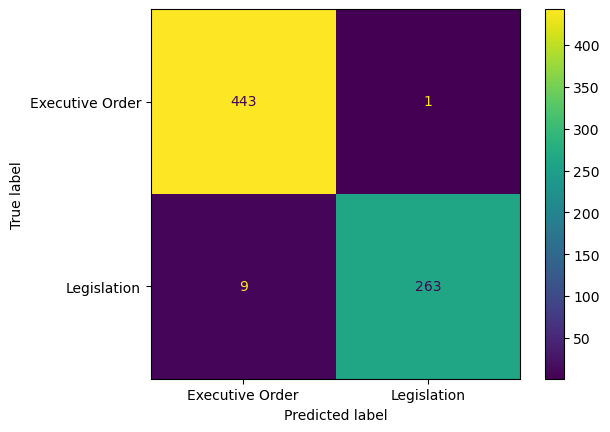

In [177]:
plot_cm(y_test, gs_rf_2)

In [178]:
def get_feature_importance(gs, model_name, vectorizer='tfidf'):
    feats = {} 
    for feature, importance in zip(gs.best_estimator_.named_steps[vectorizer].get_feature_names_out(), gs.best_estimator_.named_steps[model_name].feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    return importances.sort_values(by='Gini-importance', ascending=False).head(50)

In [179]:
get_feature_importance(gs_rf_2, 'rf', 'tfidf')

,Gini-importance
america,0.042851
cite,0.040586
enactment,0.028520
strike,0.023514
document,0.022907
stat,0.019434
insert,0.018037
know,0.015995
follow,0.015350
map,0.015341


## 5.iii XGBoost II

In [180]:
# pipe
pipe_xgb_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

# params
param_grid_xgb_2 = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (3, 3)],
    'xgb__booster': ['gbtree', 'gblinear'],
}

# grid search
gs_xgb_2 = GridSearchCV(pipe_xgb_2, param_grid_xgb_2, cv=5, n_jobs=-1)


In [181]:
gs_xgb_2.fit(X_train, y_train)

/Users/natehiatt/miniconda3/envs/capstone/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__min_df': [1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (3, 3)],
                         'xgb__booster': ['gbtree', 'gblinear']})

In [182]:
evaluate_grid(gs_xgb_2)

Best Params: {'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'xgb__booster': 'gbtree'}
Best CV Accuracy: 0.9898601398601399
Train Accuracy: 1.0


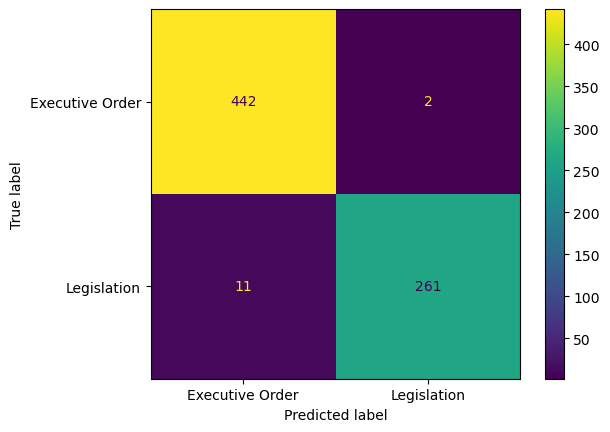

In [183]:
plot_cm(y_test, gs_xgb_2)

In [184]:
get_feature_importance(gs_xgb_2, 'xgb', 'tfidf')

,Gini-importance
map,0.233454
paper,0.221019
state america,0.127886
may cite,0.104861
disapproves,0.034093
date enactment,0.028657
record,0.019933
know,0.016047
enactment,0.015849
tribe,0.011432


# 6. Changes Over Time

## 6.i Multinomial Naive Bayes

In [192]:
# MNB 1
vectorizer_mnb1 = gs_nb.best_estimator_.named_steps['tfidf']
mobel_mnb1 = gs_nb.best_estimator_.named_steps['nb']

# matrix
X_tfidf_mnb1 = vectorizer_mnb1.transform(df['text_string'])
result_df_mnb1 = df.copy()
result_df_mnb1.reset_index(inplace=True)
result_df_mnb1["tfidf"] = X_tfidf_mnb1.toarray().tolist()

# proba
result_df_mnb1["proba"] = mobel_mnb1.predict_proba(X_tfidf_mnb1).tolist()
result_df_mnb1["proba_0"] = [x[0] for x in result_df_mnb1["proba"]]
result_df_mnb1["proba_1"] = [x[1] for x in result_df_mnb1["proba"]]
result_df_mnb1["difference"] = result_df_mnb1["proba_1"] - result_df_mnb1["proba_0"]

Text(0, 0.5, 'Average Difference in Log Probability')

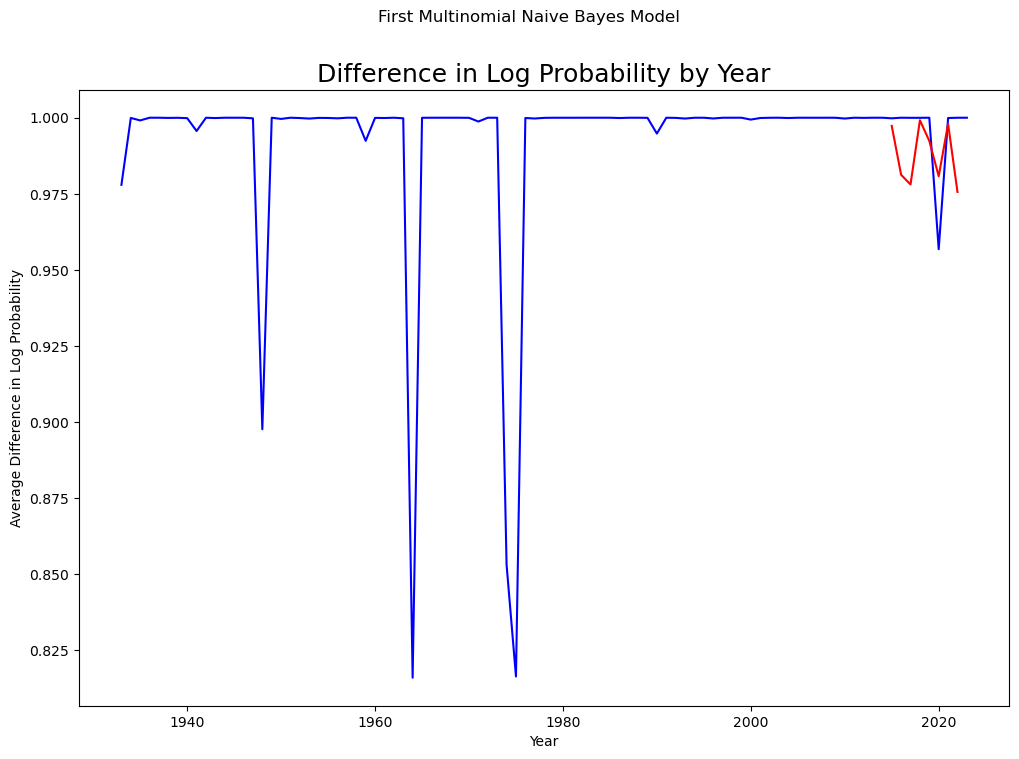

In [202]:
# plot first mnb model
grouped_data_mnb1 = result_df_mnb1.groupby(["year", "target"]).agg({"difference": "mean"}).abs().reset_index()

plt.figure(figsize=(12, 8))
for target, data in grouped_data_mnb1.groupby("target"):
    if target == 0:
        plt.plot(data['year'], data['difference'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['year'], data['difference'], label=f"Target {target}", color='red')
plt.title("Difference in Log Probability by Year", fontsize=18)
plt.suptitle("First Multinomial Naive Bayes Model", fontsize=12) 
plt.xlabel("Year")
plt.ylabel("Average Difference in Log Probability")

In [185]:
# Using 2nd MNB Model
vectorizer = gs_nb_2.best_estimator_.named_steps['tfidf']
mnb_model = gs_nb_2.best_estimator_.named_steps['nb']

# Creating tfidf matrix:
X_tfidf = vectorizer.transform(df_2['text_string'])
result_df = df_2.copy()
result_df.reset_index(inplace=True)
result_df["tfidf"] = X_tfidf.toarray().tolist()
result_df.head()

,index,year,text_string,target,tokens,cleaned_text,tfidf
0,0,1933,august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appoint, operative, s...","[august, gennerich, may, appoint, operative, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,1933,canal zoneby building locate cristobal canal z...,0,"[canal, zoneby, virtue, authority, vested, law...","[canal, zoneby, building, locate, cristobal, c...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,1933,october stat l amend march say march issue fol...,0,"[virtue, authority, vested, section, act, octo...","[october, stat, l, amend, march, say, march, i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,1933,legislative appropriation fiscal year amend co...,0,"[whereas, section, title, iv, part, ii, legisl...","[legislative, appropriation, fiscal, year, ame...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,1933,date february far relates establishment rio gr...,0,"[hereby, order, date, february, far, relates, ...","[date, february, far, relates, establishment, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [186]:
proba = mnb_model.predict_proba(X_tfidf)
result_df["proba"] = proba.tolist()
result_df["prob_0"] = [x[0] for x in result_df["proba"]]
result_df["prob_1"] = [x[1] for x in result_df["proba"]]
result_df["difference"] = result_df["prob_1"] - result_df["prob_0"]
result_df.head()

,index,year,text_string,target,tokens,cleaned_text,tfidf,proba,prob_0,prob_1,difference
0,0,1933,august gennerich may appoint operative secret ...,0,"[august, gennerich, may, appoint, operative, s...","[august, gennerich, may, appoint, operative, s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9908081165384006, 0.00919188346159625]",0.990808,0.009192,-0.981616
1,1,1933,canal zoneby building locate cristobal canal z...,0,"[canal, zoneby, virtue, authority, vested, law...","[canal, zoneby, building, locate, cristobal, c...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9912374285148869, 0.008762571485112954]",0.991237,0.008763,-0.982475
2,2,1933,october stat l amend march say march issue fol...,0,"[virtue, authority, vested, section, act, octo...","[october, stat, l, amend, march, say, march, i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9995325997794742, 0.0004674002205278232]",0.999533,0.000467,-0.999065
3,3,1933,legislative appropriation fiscal year amend co...,0,"[whereas, section, title, iv, part, ii, legisl...","[legislative, appropriation, fiscal, year, ame...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9947036047018774, 0.005296395298125371]",0.994704,0.005296,-0.989407
4,4,1933,date february far relates establishment rio gr...,0,"[hereby, order, date, february, far, relates, ...","[date, february, far, relates, establishment, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9473787951507318, 0.0526212048492697]",0.947379,0.052621,-0.894758


In [187]:
# group data by year and target; calculate mean of difference
grouped_data = result_df.groupby(["year", "target"]).agg({"difference": "mean"}).abs().reset_index()

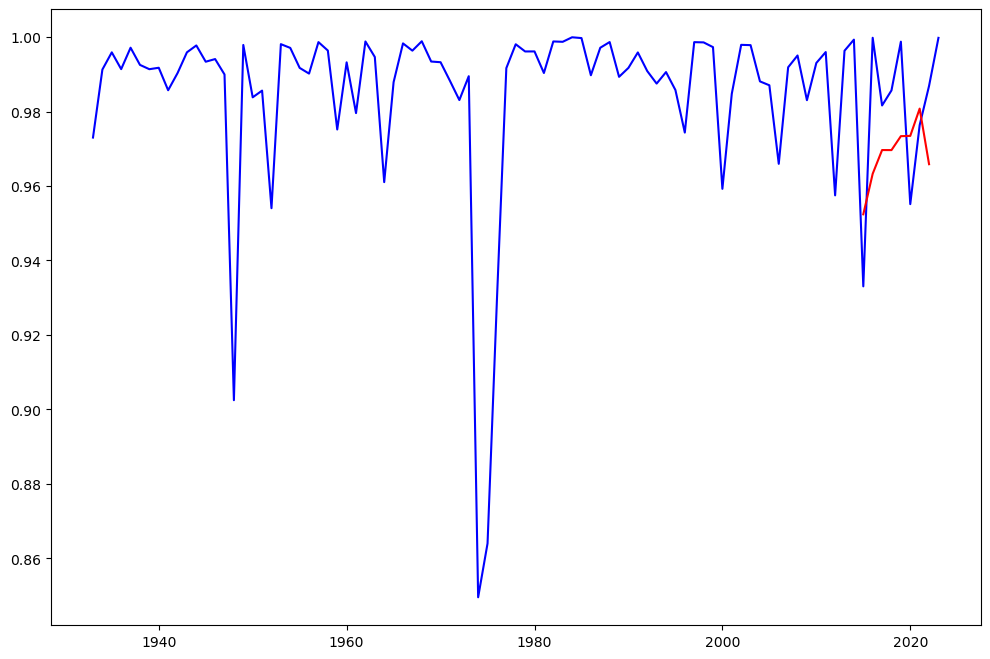

In [188]:
# plot
plt.figure(figsize=(12, 8))
for target, data in grouped_data.groupby("target"):
    if target == 0:
        plt.plot(data['year'], data['difference'], label=f"Target {target}", color='blue')
    else:
        plt.plot(data['year'], data['difference'], label=f"Target {target}", color='red')

# LDA

Resources used:
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://www.analyticsvidhya.com/blog/2023/02/topic-modeling-using-latent-dirichlet-allocation-lda/
* https://bennett-holiday.medium.com/a-step-by-step-guide-to-writing-an-lda-program-in-python-690aa99119ea

Much of the code, especially, is modelled after the third of the sources.

In [215]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

from pprint import pprint

In [227]:
# only for executive orders

id2word = corpora.Dictionary(df_2[df_2['target']==0]["cleaned_text"])
texts = df_2[df_2['target']==0]["cleaned_text"]
corpus = [id2word.doc2bow(text) for text in texts]

In [228]:
# LDA Model
lda_model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=5, 
                    random_state=1)

In [229]:
pprint(lda_model.print_topics())

[(0,
  '0.020*"shall" + 0.013*"board" + 0.010*"state" + 0.009*"secretary" + '
  '0.009*"agency" + 0.008*"dispute" + 0.007*"provide" + 0.007*"service" + '
  '0.007*"make" + 0.007*"include"'),
 (1,
  '0.031*"shall" + 0.021*"agency" + 0.016*"state" + 0.013*"secretary" + '
  '0.010*"federal" + 0.009*"include" + 0.008*"director" + 0.007*"within" + '
  '0.007*"appropriate" + 0.007*"security"'),
 (2,
  '0.031*"state" + 0.013*"include" + 0.012*"shall" + 0.011*"national" + '
  '0.011*"person" + 0.010*"emergency" + 0.009*"agency" + 0.008*"federal" + '
  '0.008*"may" + 0.008*"secretary"'),
 (3,
  '0.021*"state" + 0.020*"shall" + 0.018*"agency" + 0.011*"secretary" + '
  '0.010*"include" + 0.009*"federal" + 0.009*"person" + 0.008*"government" + '
  '0.006*"employee" + 0.006*"applicable"'),
 (4,
  '0.018*"state" + 0.017*"shall" + 0.011*"agency" + 0.011*"federal" + '
  '0.009*"follow" + 0.009*"include" + 0.008*"policy" + 0.008*"service" + '
  '0.007*"national" + 0.007*"department"')]


In [224]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

In [230]:
# https://pyldavis.readthedocs.io/en/latest/
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)

In [231]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.030775 -0.030920       1        1  26.894135
0     -0.082325  0.001279       2        1  26.394909
2      0.026775  0.058885       3        1  16.413292
4      0.014979 -0.045004       4        1  15.888617
3      0.009796  0.015759       5        1  14.409048, topic_info=          Term         Freq        Total Category  logprob  loglift
120      state  7440.000000  7440.000000  Default  30.0000  30.0000
820      board  1745.000000  1745.000000  Default  29.0000  29.0000
2131   dispute   970.000000   970.000000  Default  28.0000  28.0000
8418       rla   554.000000   554.000000  Default  27.0000  27.0000
222     person  2116.000000  2116.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
153    provide   280.289118  2284.531086   Topic5  -5.3540  -0.1608
14     service   266.389730  2290.105230   Topic5  -5.4049  -0.2141
558   national   267.788928  2519.689020   Topic5  -5.3996  -0.3044
943     policy   258.717764  2088.222391   Topic5  -5.4341  -0.1510
142        day   245.139596  1557.416994   Topic5  -5.4880   0.0884

[435 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
5816      1  0.019469  159a
5816      2  0.963711  159a
5816      3  0.009734  159a
5816      5  0.009734  159a
6056      2  0.917574    2a
...     ...       ...   ...
742       1  0.282499  work
742       2  0.234984  work
742       3  0.087255  work
742       4  0.248806  work
742       5  0.146001  work

[1308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [232]:
# Repeating for legislation
id2word = corpora.Dictionary(df_2[df_2['target']==1]["cleaned_text"])
texts = df_2[df_2['target']==1]["cleaned_text"]
corpus = [id2word.doc2bow(text) for text in texts]

# LDA Model
lda_model = LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=5, 
                    random_state=1)

pprint(lda_model.print_topics())

[(0,
  '0.018*"shall" + 0.014*"state" + 0.013*"provide" + 0.011*"secretary" + '
  '0.010*"year" + 0.009*"include" + 0.008*"available" + 0.008*"may" + '
  '0.008*"fund" + 0.007*"stat"'),
 (1,
  '0.021*"shall" + 0.013*"state" + 0.012*"secretary" + 0.009*"provide" + '
  '0.009*"program" + 0.008*"year" + 0.008*"may" + 0.008*"service" + '
  '0.008*"include" + 0.007*"available"'),
 (2,
  '0.014*"shall" + 0.011*"secretary" + 0.010*"state" + 0.009*"include" + '
  '0.008*"provide" + 0.008*"program" + 0.007*"year" + 0.007*"may" + '
  '0.007*"defense" + 0.006*"federal"'),
 (3,
  '0.019*"shall" + 0.015*"state" + 0.013*"secretary" + 0.009*"program" + '
  '0.009*"year" + 0.008*"provide" + 0.007*"fund" + 0.007*"include" + '
  '0.007*"amount" + 0.006*"service"'),
 (4,
  '0.016*"shall" + 0.013*"secretary" + 0.012*"state" + 0.009*"provide" + '
  '0.008*"year" + 0.008*"include" + 0.007*"program" + 0.007*"service" + '
  '0.007*"defense" + 0.007*"use"')]


In [233]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.005732 -0.002111       1        1  31.601358
0     -0.001124  0.005929       2        1  20.103205
4      0.003881 -0.000032       3        1  18.656805
2      0.003622 -0.001818       4        1  17.080949
3     -0.000648 -0.001969       5        1  12.557683, topic_info=          Term           Freq          Total Category  logprob  loglift
109      state   72583.000000   72583.000000  Default  30.0000  30.0000
105      shall  100821.000000  100821.000000  Default  29.0000  29.0000
104  secretary   67216.000000   67216.000000  Default  28.0000  28.0000
789    defense   26917.000000   26917.000000  Default  27.0000  27.0000
361       fund   34797.000000   34797.000000  Default  26.0000  26.0000
..         ...            ...            ...      ...      ...      ...
346    federal    3107.900590   28140.871606   Topic5  -5.4319  -0.1284
196  available    3465.793170   35832.827562   Topic5  -5.3229  -0.2611
40        date    2769.063428   25538.972493   Topic5  -5.5474  -0.1469
108       stat    2853.656436   31521.069944   Topic5  -5.5173  -0.3272
789    defense    2767.698971   26917.920612   Topic5  -5.5478  -0.1999

[449 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
8039       1  0.173169  05recreational
8039       2  0.115446  05recreational
8039       3  0.115446  05recreational
8039       4  0.461784  05recreational
8039       5  0.115446  05recreational
...      ...       ...             ...
4302       2  0.126329      zoological
4302       3  0.126329      zoological
4302       4  0.631647      zoological
4302       5  0.126329      zoological
49683      1  0.657800      ÿ7eÿ7eÿ7er

[976 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

# 7. Conclusions

1. Reliance on authorization related-words
2. Relative importance of more clerical and Post-Office-related words in legislative.
3. Hasn't seemed to harder to tell executive from legislative -- or at least, there's not a clear trend line. That may imply we should be looking elsewhere.

# 8. Next Steps

1. More data. We want the laws and executive orders to go back the same amount. Maybe the laws themselves have shifted over time, but that's hard to tell if we only have a relatively recent time-slice.
2. Other executive-related documents; not just executive orders.
3. Unsupervised learning/clustering models.